In [24]:
import json
import os
import math
import librosa
import json
import numpy as np
from sklearn.model_selection import train_test_split
import  keras
from keras.layers import Flatten
import matplotlib.pyplot as plt

In [25]:
DATASET_PATH = "./dataset/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
DATA_PATH = "./data_10.json"

In [26]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: blues
./dataset/genres_original/blues/blues.00013.wav, segment:1
./dataset/genres_original/blues/blues.00013.wav, segment:2
./dataset/genres_original/blues/blues.00013.wav, segment:3
./dataset/genres_original/blues/blues.00013.wav, segment:4
./dataset/genres_original/blues/blues.00013.wav, segment:5
./dataset/genres_original/blues/blues.00013.wav, segment:6
./dataset/genres_original/blues/blues.00013.wav, segment:7
./dataset/genres_original/blues/blues.00013.wav, segment:8
./dataset/genres_original/blues/blues.00013.wav, segment:9
./dataset/genres_original/blues/blues.00013.wav, segment:10
./dataset/genres_original/blues/blues.00008.wav, segment:1
./dataset/genres_original/blues/blues.00008.wav, segment:2
./dataset/genres_original/blues/blues.00008.wav, segment:3
./dataset/genres_original/blues/blues.00008.wav, segment:4
./dataset/genres_original/blues/blues.00008.wav, segment:5
./dataset/genres_original/blues/blues.00008.wav, segment:6
./dataset/genres_original/blues/blue

In [27]:
# DATA_PATH = "./data_10.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [28]:
def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [29]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    model.add(Flatten())

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [30]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

2023-04-23 12:17:04.299902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 12:17:04.302076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 12:17:04.303897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trai

In [32]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

Epoch 1/10


2023-04-23 12:17:05.307021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 12:17:05.311918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 12:17:05.313816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 2.2171 - accuracy: 0.2055

2023-04-23 12:17:29.822215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 12:17:29.824334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 12:17:29.825839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - 27s 121ms/step - loss: 2.2171 - accuracy: 0.2055 - val_loss: 2.0904 - val_accuracy: 0.3438
Epoch 2/10
188/188 [==============================] - 22s 119ms/step - loss: 1.9877 - accuracy: 0.3253 - val_loss: 1.8193 - val_accuracy: 0.4059
Epoch 3/10
188/188 [==============================] - 22s 115ms/step - loss: 1.7742 - accuracy: 0.3914 - val_loss: 1.6221 - val_accuracy: 0.4513
Epoch 4/10
188/188 [==============================] - 22s 114ms/step - loss: 1.6357 - accuracy: 0.4293 - val_loss: 1.5004 - val_accuracy: 0.4920
Epoch 5/10
188/188 [==============================] - 22s 116ms/step - loss: 1.5402 - accuracy: 0.4669 - val_loss: 1.4429 - val_accuracy: 0.5047
Epoch 6/10
188/188 [==============================] - 22s 115ms/step - loss: 1.4904 - accuracy: 0.4836 - val_loss: 1.3949 - val_accuracy: 0.5227
Epoch 7/10
188/188 [==============================] - 22s 117ms/step - loss: 1.4228 - accuracy: 0.5109 - val_loss: 1.3733 - val_accuracy: 0.5

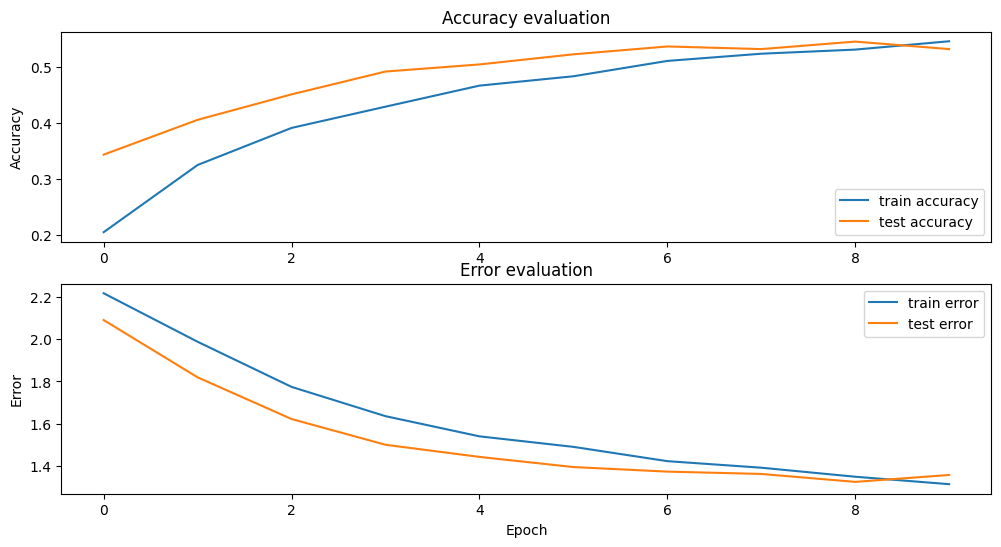

In [33]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """
    #fig, axs = plt.subplots(2)
    fig, axs = plt.subplots(2,1, figsize=(12,6))
    


    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error evaluation")

    plt.show()


# plot accuracy/error for training and validation
plot_history(history)


In [34]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 3s - loss: 1.3818 - accuracy: 0.5094 - 3s/epoch - 33ms/step

Test accuracy: 0.5094112753868103
